# Data Cleaning, Feature Engineering, and Model Comparison for Credit Risk Prediction in Auto Credits


## Summary


This code provides a workflow for preparing, cleaning, and analyzing an auto credit risk dataset to predict customer defaults. The process involves data inspection, cleaning, label encoding for categorical features, and standard scaling for numeric features.  
Logistic regression models are built and compared: basic logistic regression, logistic regression with hyperparameter tuning via RandomizedSearchCV, and logistic regression with cross-validation. Model performance is evaluated using accuracy and ROC AUC scores, with a comparative ROC curve plotted to assess model effectiveness.  
The results show that the RandomizedSearchCV Logistic Regression model achieves the highest accuracy but the lowest ROC AUC score, indicating weaker performance across varying thresholds. This highlights the trade-off between higher accuracy at a fixed threshold and more balanced classification performance in other models.  
Further parameter tuning or alternative methods may improve decision-making reliability. The first table compares accuracy scores, the second table shows ROC values, and the figure shows the ROC curves for the three models.


Initial Data Types:
ID                              int64
Client_Income                  object
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                  object
Loan_Annuity                   object
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative     object
Age_Days                       object
Employed_Days                  object
Registration_Days              object
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation             

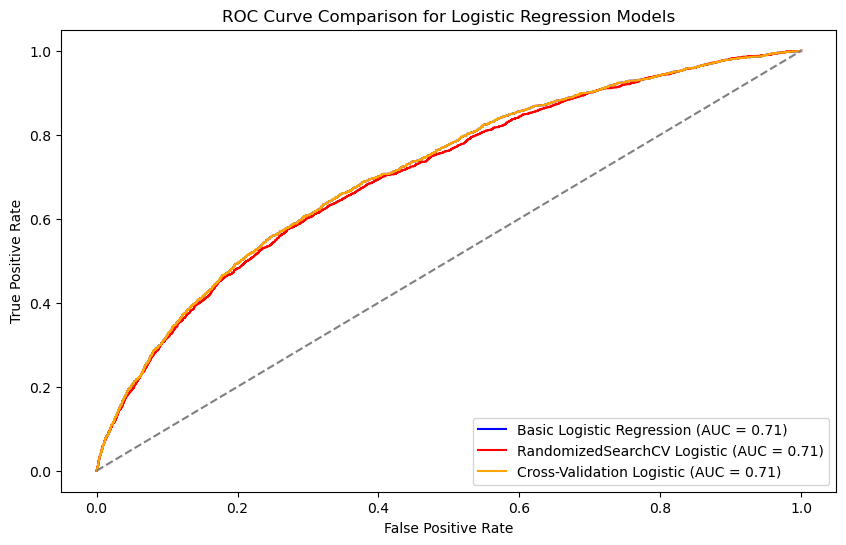

In [9]:
# ===========================================================
# Section 1: Import Libraries
# ===========================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn preprocessing and polynomial features
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

# Sklearn classifiers and model selection
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier  # For Randomized CV if needed

# Sklearn metrics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
from tabulate import tabulate

# ===========================================================
# Section 2: Load and Check Data for Errors
# ===========================================================

# Load the dataset
df = pd.read_csv('AutoCredit.csv',low_memory=False)

# Check the data types of the columns
print("Initial Data Types:")
print(df.dtypes)

# Inspect the first few rows to understand the structure
print("\nFirst 5 rows of data:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicates
print("\nCheck for duplicate rows:")
print(df.duplicated().sum())

# Check for inconsistent or unexpected values in categorical columns
print("\nUnique values per column (for categorical columns):")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")

# Check for inconsistent or unexpected characters in numeric columns
print("\nCheck for non-numeric characters in numeric columns:")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    print(f"\nValues in column {col} that are not numeric:")
    non_numeric_values = df[~df[col].apply(pd.to_numeric, errors='coerce').notna()]
    print(non_numeric_values)

# Check for extreme values or outliers in numeric columns
print("\nCheck for summary statistics of numeric columns:")
print(df.describe())

# Check for categorical data that may need label encoding
print("\nUnique values in categorical columns for potential label encoding:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique values")
    
# ===========================================================
# Section 3: Clean Data
# ===========================================================

# Read the data
dtype_dict = {
    'ID': 'str',  # Keep ID as string
    'Client_Income': 'str',  # Read as string initially to clean
    'Credit_Amount': 'str',  # Read as string initially to clean
    'Loan_Annuity': 'str',  # Read as string initially to clean
    'Accompany_Client': 'str',
    'Client_Income_Type': 'str',
    'Client_Education': 'str',
    'Client_Marital_Status': 'str',
    'Client_Gender': 'str',
    'Loan_Contract_Type': 'str',
    'Client_Housing_Type': 'str',
    'Population_Region_Relative': 'str',
    'Age_Days': 'str',  # Read as string to clean
    'Employed_Days': 'str',  # Read as string to clean
    'Registration_Days': 'str',  # Read as string to clean
    'ID_Days': 'str',  # Read as string to clean
    'Client_Occupation': 'str',
    'Client_Permanent_Match_Tag': 'str',
    'Client_Contact_Work_Tag': 'str',
    'Type_Organization': 'str',
    'Score_Source_3': 'str'  # Read as string to clean
}

df = pd.read_csv('AutoCredit.csv', dtype=dtype_dict, low_memory=False)

# --- Clean numeric columns with non-numeric characters ---
def clean_numeric_columns(df):
    # List columns that should be numeric
    numeric_columns = ['Client_Income', 'Credit_Amount', 'Loan_Annuity', 'Age_Days', 'Employed_Days', 
                       'Registration_Days', 'ID_Days']
    
    for column in numeric_columns:
        if df[column].dtype == 'object':  # Only process object type columns
            # Remove any dollar signs, commas, etc.
            df[column] = df[column].replace({r'\$': '', ',': ''}, regex=True)  # Use raw string for regex
            # Attempt to convert the cleaned column to numeric, forcing errors to NaN
            df[column] = pd.to_numeric(df[column], errors='coerce')
    
    return df

# Clean the DataFrame by removing non-numeric characters
df = clean_numeric_columns(df)

# --- Handle Missing Values ---
def map_columns(df):
    # Define the mapping for Client_Income_Type    
    cluster_mapping_income_type = {
        "Transport: type 1": "Others",
        "Industry: type 10 ": "Others",
        "Industry: type 6": "Others",
        "Religion": "Others",
        "Industry: type 13": "Others",
        "Trade: type 4": "Others",
        "Industry: type 8": "Others",
        "Student": "other",
        "Unemployed": "other",
        "Maternity leave": "other",
        "Businessman": "other"
    }
    
    # Define the mapping for Client_Education
    cluster_mapping_education = {
        "Post Grad": "Graduate"
    }
    
    # Define the mapping for Accompany_Client
    cluster_mapping_accompany = {
        "##": "Others",
        "Group": "Others"
    }
    
    # Apply the mapping for Client_Income_Type
    df["Client_Income_Type"] = df["Client_Income_Type"].replace(cluster_mapping_income_type)
    
    # Apply the mapping for Client_Education
    df["Client_Education"] = df["Client_Education"].replace(cluster_mapping_education)
    
    # Apply the mapping for Accompany_Client
    df["Accompany_Client"] = df["Accompany_Client"].replace(cluster_mapping_accompany)
    
    # Return the updated DataFrame
    return df

# Apply mapping to the DataFrame
df = map_columns(df)

# Replace "x" by NaN for the column: ID_Days
mask = df["ID_Days"] == "x"
df.loc[mask, "ID_Days"] = np.nan

# Fill missing values for categorical columns with the mode (most frequent value)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Identify numeric columns that are entirely empty
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Remove columns with all missing values before applying imputation
empty_cols = df[numeric_cols].columns[df[numeric_cols].isnull().all()]
df.drop(columns=empty_cols, inplace=True)

# Now apply imputation only to columns with non-empty data
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# --- Label Encoding for non-numeric columns ---
def label_encode_columns(df):
    le = LabelEncoder()
    # Apply label encoding to categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

# Apply label encoding to the DataFrame
df = label_encode_columns(df)

# --- Data Scaling & Clustering ---
# Check if your selected clustering columns exist in the DataFrame
cluster_cols = ['Credit_Amount', 'Client_Income', 'Credit_Bureau', 'Age_Days']  # Example updated columns

# Ensure that the cluster columns exist in the dataframe
missing_cols = [col for col in cluster_cols if col not in df.columns]
if missing_cols:
    print(f"Warning: The following columns are missing from the dataset: {missing_cols}")
else:
    # Standardize the data before clustering
    scaler = StandardScaler()
    cluster_data = df[cluster_cols]

    # Apply scaling to the selected cluster columns
    cluster_data_scaled = scaler.fit_transform(cluster_data)

# --- Check Missing Values After Cleaning ---
print("Remaining missing values after cleaning:")
print(df.isnull().sum())

#  Save the cleaned data to a new CSV file ---
df.to_csv('AutoCredit_cleaned.csv', index=False)


# ===========================================================
# Section 4: Preprocessing and Feature Engineering
# ===========================================================

# Create dummy variables for categorical features 
X = pd.get_dummies(df.drop('Default', axis=1), drop_first=True)  # drop_first=True avoids dummy variable trap
y = df['Default']

# Split data into training and test sets for the first model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ===========================================================
# Section 5: Comparison of Logistic Regression Models
# ===========================================================

# 1. Basic Logistic Regression
log_reg_basic = LogisticRegression(solver='liblinear', max_iter=600)
log_reg_basic.fit(X_train_scaled, y_train)
y_prob_basic = log_reg_basic.predict_proba(X_test_scaled)[:, 1]
roc_auc_basic = roc_auc_score(y_test, y_prob_basic)
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_prob_basic)

# 2. Logistic Regression with RandomizedSearchCV (simplified for speed)
param_dist = {
    'C': np.logspace(-3, 3, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [300, 600]
}
random_search = RandomizedSearchCV(log_reg_basic, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)
y_prob_random = random_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]
roc_auc_random = roc_auc_score(y_test, y_prob_random)
fpr_random, tpr_random, _ = roc_curve(y_test, y_prob_random)

# 3. Logistic Regression with Cross-Validation
cv_scores = cross_val_score(log_reg_basic, X_train_scaled, y_train, cv=3, scoring='accuracy')
log_reg_cv = LogisticRegression(solver='liblinear', max_iter=200)
log_reg_cv.fit(X_train_scaled, y_train)
y_prob_cv = log_reg_cv.predict_proba(X_test_scaled)[:, 1]
roc_auc_cv = roc_auc_score(y_test, y_prob_cv)
fpr_cv, tpr_cv, _ = roc_curve(y_test, y_prob_cv)


# ===========================================================
# Section 6: Model Comparison and Performance Evaluation
# ===========================================================

# Model Comparison Data
model_comparison_data = [
    ["Basic Logistic Regression", log_reg_basic.score(X_test_scaled, y_test)],
    ["RandomizedSearchCV Logistic", random_search.best_estimator_.score(X_test_scaled, y_test)],
    ["Cross-Validation Logistic", cv_scores.mean()]
]

# Print model comparison table
print("\nModel Comparisons:")
print(tabulate(model_comparison_data, headers=["Model", "Accuracy"], tablefmt="grid", floatfmt=".4f"))

# ROC AUC Score Data
roc_auc_data = [
    ["Basic Logistic Regression", roc_auc_basic],
    ["RandomizedSearchCV Logistic", roc_auc_random],
    ["Cross-Validation Logistic", roc_auc_cv]
]

# Print ROC AUC table
print("\nROC AUC Scores:")
print(tabulate(roc_auc_data, headers=["Model", "ROC AUC Score"], tablefmt="grid", floatfmt=".4f"))

# Plot ROC curves for all models
print("\n") 
plt.figure(figsize=(8, 4))
plt.plot(fpr_basic, tpr_basic, color='b', label=f'Basic Logistic Regression (AUC = {roc_auc_basic:.2f})')
plt.plot(fpr_random, tpr_random, color='r', label=f'RandomizedSearchCV Logistic (AUC = {roc_auc_random:.2f})')
plt.plot(fpr_cv, tpr_cv, color='orange', label=f'Cross-Validation Logistic (AUC = {roc_auc_cv:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.title('ROC Curve Comparison for Logistic Regression Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
